In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from sklearn.preprocessing import MinMaxScaler

In [2]:
torch.backends.cudnn.benchmark = True
torch.backends.cudnn.enabled = True

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

This notebook demonstrates the models used for the project

## Load data

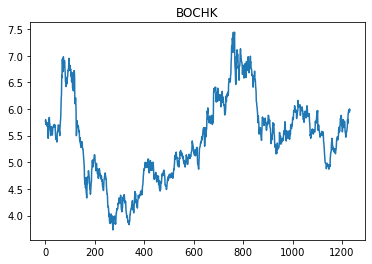

<Figure size 432x288 with 0 Axes>

In [4]:
df = pd.read_csv("Data/ICBC.csv")
    
plt.plot(df.Close)
plt.title("BOCHK")
plt.show()
plt.clf()

df = df[["Date", "Close"]]

In [5]:
df.head()

,Date,Close
0,2015-01-02,5.77
1,2015-01-05,5.80
2,2015-01-06,5.71
3,2015-01-07,5.75
4,2015-01-08,5.72


In [6]:
df_close = df.Close.to_numpy().reshape(-1,1)
df_close.shape

(1232, 1)

### Data split 
The first 80% for training, the next 20% for validating, and the last 20% for testing

In [7]:
training_ind = int(len(df_close)*0.6)
validating_ind = int(len(df_close)*0.8)

training_set = df_close[:training_ind]
validation_set = df_close[training_ind:validating_ind]
test_set = df_close[validating_ind:]

training_set.shape, validation_set.shape, test_set.shape

((739, 1), (246, 1), (247, 1))

### Data preprocessing

In [8]:
# Scale data to the range of (-1,1)
scaler = MinMaxScaler(feature_range=(-1,1))
scaler.fit(training_set)

MinMaxScaler(feature_range=(-1, 1))

In [9]:
# The input is an l-step time series and the output is a p-step time-series
def sliding_window(dataset, l, p, scaler, device):
    x, y = [], []

    for i in range(len(dataset)-l-p+1):
        #Get input of size l, starting from index i
        _x = dataset[i: i+l, :]
        _x = scaler.transform(_x)

        #Get the next p values as label
        _y = dataset[i+l: i+l+p, 0].reshape(-1,1)
        _y = scaler.transform(_y)

        x.append(_x)
        y.append(_y)

    x = np.array(x)
    y = np.array(y)
    
    x = torch.tensor(x).to(dtype=torch.float32).to(device)
    y = torch.tensor(y).to(dtype=torch.float32).to(device)

    return (x, y)

In [10]:
# Reverse scale data for indication
def reverse_normalize(x, scaler):
    x = x.reshape(-1,1).to('cpu')
    x = scaler.inverse_transform(x)
    
    x = torch.tensor(x).to(dtype=torch.float32)
    return x

In [11]:
epochs = 100
l = 22
p = 1

In [12]:
trainX, trainY = sliding_window(training_set, l, p, scaler, device)
valX, valY = sliding_window(validation_set, l, p, scaler, device)
testX, testY = sliding_window(test_set, l, p, scaler, device)

trainX.shape, trainY.shape, valX.shape, valY.shape, testX.shape, testY.shape

(torch.Size([717, 22, 1]),
 torch.Size([717, 1, 1]),
 torch.Size([224, 22, 1]),
 torch.Size([224, 1, 1]),
 torch.Size([225, 22, 1]),
 torch.Size([225, 1, 1]))

In [13]:
# Loss and indicator functions
def MAPE(x, y):
    return torch.mean(torch.abs((y - x) / y)) 

def RMSE(x, y):
    criterion = nn.MSELoss()
    return torch.sqrt(criterion(x, y))

def R2(x, y):
    target_mean = torch.mean(y)
    ss_tot = torch.sum((y - target_mean) ** 2)
    ss_res = torch.sum((y - x) ** 2)
    
    r2 = 1 - ss_res / ss_tot
    
    return r2

def indicator(x, y, scaler):
    x = reverse_normalize(x, scaler)
    y = reverse_normalize(y, scaler)
    
    mape = MAPE(x, y).item()
    rmse = RMSE(x, y).item()
    r2 = R2(x, y).item()
    
    return mape, rmse, r2

# Train models

In [14]:
def train_model(net, optimizer, criterion, epochs, trainX, trainY, valX, valY, scaler):
    mse_train = np.zeros(epochs)
    mse_val = np.zeros(epochs)

    mape_train = np.zeros(epochs)
    mape_val = np.zeros(epochs)

    rmse_train = np.zeros(epochs)
    rmse_val = np.zeros(epochs)

    r2_train = np.zeros(epochs)
    r2_val = np.zeros(epochs)

    for epoch in range(epochs):    
        optimizer.zero_grad()

        pred = net(trainX)

        loss = criterion(pred, trainY)

        loss.backward()
        optimizer.step()

        mse_train[epoch] = loss.item()

        results = indicator(pred.detach(), trainY, scaler)
        mape_train[epoch] = results[0]
        rmse_train[epoch] = results[1]
        r2_train[epoch] = results[2]

        if epoch == 0 or (epoch + 1) % 100 == 0:
            print(f'epoch: {epoch+1:3}')
            print(f'loss: {loss.item():10.8f}')

        with torch.no_grad():
            val_pred = net(valX)

            error = criterion(val_pred, valY)

            if epoch == 0 or (epoch + 1) % 100 == 0:
                print(f'validation loss: {error.item():10.8f}')

            mse_val[epoch] = error.item()

            results = indicator(val_pred.detach(), valY, scaler)
            mape_val[epoch] = results[0]
            rmse_val[epoch] = results[1]
            r2_val[epoch] = results[2]
            
    return mse_train, mse_val, mape_train, mape_val, rmse_train, rmse_val, r2_train, r2_val

In [15]:
def visualize_result(train, val, name):
    epoch = range(1, len(train)+1)

    plt.plot(epoch, train, label='Training')
    plt.plot(epoch, val, label='Validating')

    plt.title(name)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()
    plt.clf()

In [16]:
def test_model(net, testX, testY, scaler):
    net.eval()
    pred = net(testX)
    
    loss = criterion(pred, testY)
    print(f'MSE: {loss.item():10.8f}')
    
    results = indicator(pred.detach(), testY, scaler)
    
    print(f'MAPE: {results[0]:10.8f}')
    print(f'RMSE: {results[1]:10.8f}')
    print(f'R2: {results[2]:10.8f}')

    label = reverse_normalize(testY, scaler).numpy().flatten()
    pred = reverse_normalize(pred.detach(), scaler).numpy().flatten()

    plt.plot(range(len(label)), label, label='Ground truth')
    plt.plot(range(len(label)), pred, label='Prediction')

    plt.title('Test')
    plt.xlabel('Session')
    plt.ylabel('Close')
    plt.legend()

    plt.show()

## Multilayer Perceptron

In [17]:
class MLP(nn.Module):

    def __init__(self, l=22, p=1):
        super(MLP, self).__init__()
        
        self.l = l
        self.p = p

        self.l1 = nn.Linear(l, 128)
        self.l2 = nn.Linear(128, 64)
        self.l3 = nn.Linear(64, 16)
        
        self.output = nn.Linear(16, p)
        

    def forward(self, x):
        batch_size = x.size(0)
        x = x.reshape(-1, self.l)
        
        x = self.l1(x)
        x = F.relu(x)
        
        x = self.l2(x)
        x = F.relu(x)
        
        x = self.l3(x)
        x = F.relu(x)
        
        x = self.output(x)

        return x.reshape(batch_size, -1, self.p)

In [18]:
net = MLP(l, p)

if torch.cuda.is_available():
    net.cuda()

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.005)

print(net)

MLP(
  (l1): Linear(in_features=22, out_features=128, bias=True)
  (l2): Linear(in_features=128, out_features=64, bias=True)
  (l3): Linear(in_features=64, out_features=16, bias=True)
  (output): Linear(in_features=16, out_features=1, bias=True)
)


In [19]:
mse_train, mse_val, mape_train, mape_val, rmse_train, rmse_val, r2_train, r2_val = train_model(net, optimizer, criterion, epochs, trainX, trainY, valX, valY, scaler)

epoch:   1
loss: 0.23272873
validation loss: 0.24746600
epoch: 100
loss: 0.00276462
validation loss: 0.00549860


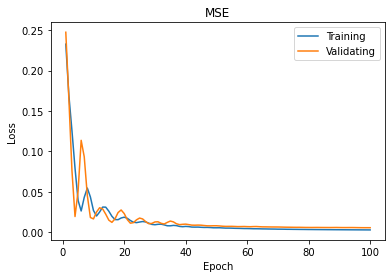

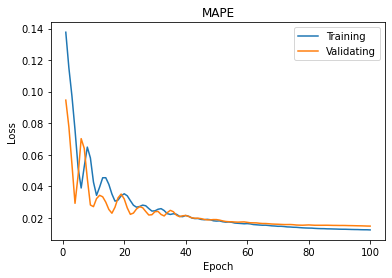

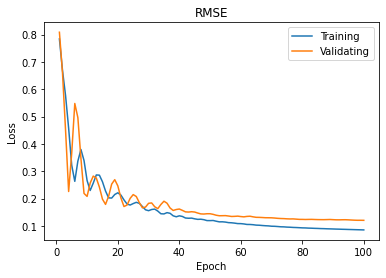

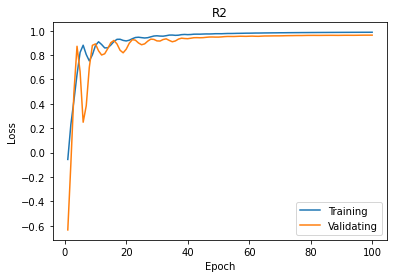

<Figure size 432x288 with 0 Axes>

In [20]:
visualize_result(mse_train, mse_val, "MSE")
visualize_result(mape_train, mape_val, "MAPE")
visualize_result(rmse_train, rmse_val, "RMSE")
visualize_result(r2_train, r2_val, "R2")

MSE: 0.00226558
MAPE: 0.01038962
RMSE: 0.07734685
R2: 0.94327623


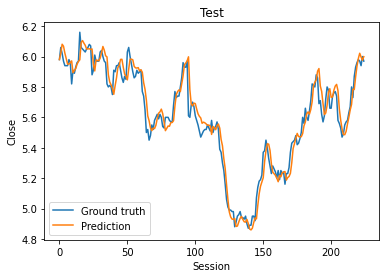

In [21]:
test_model(net, testX, testY, scaler)

## Long Short Term Memory

In [22]:
class LSTM(nn.Module):

    def __init__(self, l=22, p=1):
        super(LSTM, self).__init__()
        
        self.l = l
        self.p = p

        self.l1 = nn.LSTM(l, 128, batch_first=True)
        self.l2 = nn.LSTM(128, 64, batch_first=True)
        self.l3 = nn.Linear(64, 16)
        self.output = nn.Linear(16, p)
        

    def forward(self, x):
        batch_size = x.size(0)
        x = x.reshape(batch_size, -1, self.l)
        
        x, _ = self.l1(x)
        x, _ = self.l2(x)
        
        x = self.l3(x)
        x = F.relu(x)
        
        x = self.output(x[:,-1,:])

        return x.reshape(batch_size, -1, self.p)

In [23]:
net = LSTM(l, p)

if torch.cuda.is_available():
    net.cuda()

crition = nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.005)

print(net)

LSTM(
  (l1): LSTM(22, 128, batch_first=True)
  (l2): LSTM(128, 64, batch_first=True)
  (l3): Linear(in_features=64, out_features=16, bias=True)
  (output): Linear(in_features=16, out_features=1, bias=True)
)


In [24]:
mse_train, mse_val, mape_train, mape_val, rmse_train, rmse_val, r2_train, r2_val = train_model(net, optimizer, criterion, epochs, trainX, trainY, valX, valY, scaler)

epoch:   1
loss: 0.23632510
validation loss: 0.36882275
epoch: 100
loss: 0.00396541
validation loss: 0.00724527


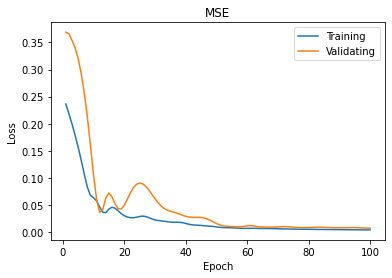

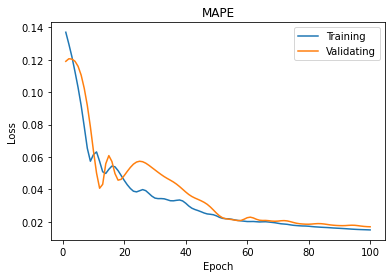

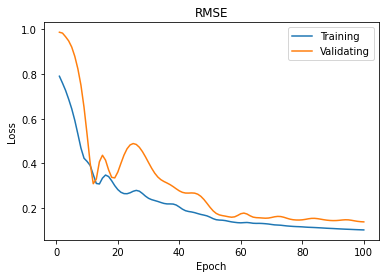

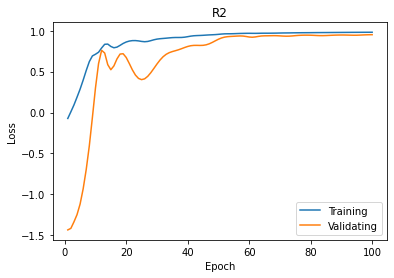

<Figure size 432x288 with 0 Axes>

In [25]:
visualize_result(mse_train, mse_val, "MSE")
visualize_result(mape_train, mape_val, "MAPE")
visualize_result(rmse_train, rmse_val, "RMSE")
visualize_result(r2_train, r2_val, "R2")

MSE: 0.00320394
MAPE: 0.01257354
RMSE: 0.09198038
R2: 0.91978234


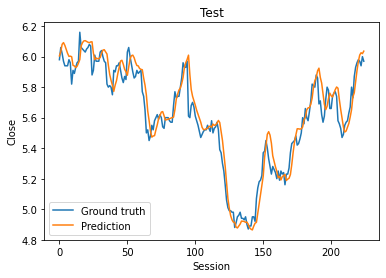

In [26]:
test_model(net, testX, testY, scaler)